# Final exam
# YourUserID: xxxxxxxx
## General 
The instruction for the final exam for DS2000B/IS2002B is included in this Jupyter Notebook. 
Some basic rules: 
- You are allowed to use any document and source on your computer and look up documents on the internet. 
- You or not allowed to share documents, or communicate in any other way with people about the final during the 6hr period after the start of the final (2 pm - 8 pm April 23d). 
- You are only allowed to use the packages listed under "preliminaries" - the use of other regression or machine learning toolboxes is not permitted. 
- All the code you are using from previous Assignments or Labs need to be included in the notebook. 
- Most questions also require some written answer. The answer to these questions should be given in full English sentences. 
- All Figures should be appropriately labeled and should have a figure caption. 
- The Final exam needs to be submitted on OWL (Assignments->Final) before 6 pm (unless you have an extension.)

## Preliminaries

In [1]:
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt 
%matplotlib inline
import scipy.stats as ss
import pandas as pd 
import numpy as np
import scipy.optimize as so
import seaborn as sns

In [44]:
#from assignment 11
def multRegPredict(b,D,xname):
    yp=np.ones(len(D.index))*b[0]        # Intercept 
    for i in range(len(xname)): 
        yp=yp+D[xname[i]]*b[i+1]         # Add each regression value
    return yp 

def multRegLossRSS(b,D,y,xname):
    predY = multRegPredict(b,D,xname)
    res = y-predY
    rss = sum(res**2)
    grad=np.zeros(len(b))
    grad[0]=-2*np.sum(res)
    for i in range(len(xname)):
        grad[i+1]=-2*np.sum(D[xname[i]]*res)
    return (rss,grad)

def multRegFit(D,y,xname,figure=0,b0=[]):
    k=len(xname)+1
    if (len(b0)!=k):
        b0=np.zeros((k,1))
    RES = so.minimize(multRegLossRSS,b0,args=(D,y,xname),jac=True)
    b=RES.x # Results
    res = y-np.mean(y)
    TSS = sum(res**2)
    RSS,deriv = multRegLossRSS(b,D,y,xname)
    R2 = 1-RSS/TSS 
    if (k==2 and figure==1):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(D[xname[0]],y)
        xRange=[min(D[xname[0]]),max(D[xname[0]])]
        xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
        yp=b[0]+b[1]*xp
        ax.plot(xp,yp,'r-')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return (R2,b)

def smMultReg(df,yname,xform):
    formula = yname + ' ~ ' + xform 
    # call the statsmodels and fit the model
    model_fit = smf.ols(formula, data = df).fit()

    # get the parameters and convert it to numpy array
    #print(type(model_fit.params))
    coefs = np.array(model_fit.params)
    #print(coefs[1]) # for debugging
    
    #print(model_fit.summary()) # for debugging
    # R2
    yp = model_fit.predict(D)
    y= D[yname]
    RSS = np.sum((y - yp)**2)
    TSS = np.sum((y - y.mean())**2)
    R2= 1- RSS/TSS
    R2
    return coefs, R2

def leaveOneOutCV(D,yname,xform):
    formula = yname + ' ~ ' + xform 
    N = len(D[yname]) #Number of observations 
    yp= np.zeros(N)
    ind = np.arange(N)
    #print(ind)
    for i in range(N):
        #print(type(df.loc[ind!=i]))
        model=smf.ols(formula,data=D.loc[ind!=i]).fit()
        yp[i]=model.predict(D.loc[ind==i])
        
    y = D[yname]
    TSS  = sum((y-y.mean())**2)
    RSS = sum((y-yp)**2)
    R2cv = 1-RSS/TSS
    return R2cv

def bootstrapReg(D,y,args,fitfcn,numIter=1000):
    r2, b=fitfcn(D,y,args)
    numParams=len(b)
    N = len(D.index) # number of data points
    ind  = np.arange(N) # a numpy array containing the indices
    stats = np.zeros((numIter,numParams)) # preallocating the np array for parameters (each column will be the distribution for a parameter)
    for i in range(numIter):
        sample = np.random.choice(ind,N) # sampling with replacement
        r2 , stats[i, :]=fitfcn(D.iloc[sample],y[sample],args)
    return stats

def confidenceInt(data,perc):
    Int=(np.percentile(data,(100-perc)/2),np.percentile(data,100-(100-perc)/2))
    return Int

def KfoldCVmultReg(D,y,args=(),K=20,fitfcn=multRegFit,predictfcn=multRegPredict):
    N = len(y) #Number of observations
    yp= np.zeros(N)
    ind = np.arange(N)
    ind = np.floor(ind/N*K)
    
    # Get overall model fit 
    R2,b_all=fitfcn(D,y,args)

    # Loop over the crossvalidation folds 
    for i in range(K):
        r,b=fitfcn(D[ind!=i],y[ind!=i],args,b0=b_all,figure=0)
        yp[ind==i]=predictfcn(b,D[ind==i],args)
        
    # Calculate crossvalidated model fit 
    TSS  = sum((y-y.mean())**2)
    RSScv = sum((y-yp)**2)
    R2cv = 1-RSScv/TSS
    return R2cv

def logisticRegFit(D,y,xname,figure=0,b0=[]):
    k=len(xname)+1
    if (len(b0)!=k):
        b0=np.zeros(k)
    RES = so.minimize(logisticRegLoss,b0,args=(D,y,xname),jac=True)
    b = RES.x
    ll = -RES.fun # Negative function value is the log likelihood 
    p = logisticRegPredict(b,D,xname)
    if (figure==1):
        fig = plt.figure()
        ax = fig.add_subplot(1,1,1)
        ax.scatter(D[xname[0]],y)
        xRange=[min(D[xname[0]]),max(D[xname[0]])]
        xp=np.arange(xRange[0],xRange[1],(xRange[1]-xRange[0])/50)
        yp=b[0]+b[1]*xp
        pp=np.exp(yp)/(1+np.exp(yp))
        ax.plot(xp,pp,'r-')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    return (ll,b)

def logisticRegLoss(b,D,y,xname):
    p = logisticRegPredict(b,D,xname)
    cost = -y*np.log(p)-(1-y)*np.log(1-p)
    N=len(xname)
    grad=np.zeros(N+1)
    res = y-p
    grad[0]=-sum(res)
    for i in range(N):
        grad[i+1]=-np.sum(D[xname[i]]*res)         # Add each regressor 
    return (cost.sum(),grad)

def logisticRegPredict(b,D,xname):
    yp=np.ones(len(D.index))*b[0]       # Start out with the intercept  
    for i in range(len(xname)):
        yp=yp+D[xname[i]]*b[i+1]        # Add the prediction of each regressor seperately 
    p = np.exp(yp)/(1+np.exp(yp))
    p[p<1e-12]=1e-12
    p[p>(1-(1e-12))]=1-(1e-12)
    return p

def KfoldCVlogisticReg(D,y,args=(),K=20,fitfcn=logisticRegFit,predictfcn=logisticRegPredict):
    N = len(y) #Number of observations
    yp= np.zeros(N)
    ind = np.arange(N)
    ind = np.floor(ind/N*K)
    
    # Get overall model fit 
    LL,b_all=fitfcn(D,y,args)
    
    # Loop over the crossvalidation folds 
    for i in range(K):
        r,b=fitfcn(D[ind!=i],y[ind!=i],args,b0=b_all,figure=0)
        yp[ind==i]=predictfcn(b,D[ind==i],args)
    LLcv = sum(y*np.log(yp)+(1-y)*np.log(1-yp))
    return LLcv 

## Data set

The data frame contains the total number of confirmed Covid-19 infections, vaccination data, and number of deaths as of March 8th, 2022, across 79 countries. It also contains some basic socio-economic data from these countries. 
- continent: Asia, Europe, Africa, Oceania, North America, South America. 
- country: Name of the country 
- total_cases: total number of COVID cases by March 8th, 2022
- total_deaths: total number of COVID19 deaths by March 8th, 2022
- total_vaccinations: total number of vaccines 
- people_fully_vaccinated: number of people who had two doses of vaccine 
- population: Population size 
- median_age: Median Age of the population 
- gdp_per_capita: Gross Domestic Product (GDP) per capita in US Dollars
- diabetes_prevalence: share of the population with diabetes
- hospital_beds: Number of Hospital beds per 1000 inhabitants 
- life_expectancy: life expectancy in years
- HDI: Human Development Index. A composite index combining life expectancy, years of education, and GDP per capita.

## Task 1: Vaccination rate (40 pts)
In this task we are looking at vaccination rate across different countries.

### Question 1 (3 pts) 
Load the data set 'covid19_2022.csv'. How many observations and variables do you have? Show the first few rows.

In [3]:
df = pd.read_csv('covid_2022.csv')
print(df.shape)
print(df.columns)

(79, 13)
Index(['continent', 'country', 'total_cases', 'total_deaths',
       'total_vaccinations', 'people_fully_vaccinated', 'population',
       'median_age', 'gdp_per_capita', 'diabetes_prevalence', 'hospital_beds',
       'life_expectancy', 'HDI'],
      dtype='object')


Written answer: The dataset has 79 observations and 13 variables. (2 points, 1 point for displaying the first rows)

In [4]:
df.head()

,continent,country,total_cases,total_deaths,total_vaccinations,people_fully_vaccinated,population,median_age,gdp_per_capita,diabetes_prevalence,hospital_beds,life_expectancy,HDI
0,Africa,Angola,98829,1900,16850195.0,5699666,33933611,16.8,5819.495,3.94,0.800,61.15,0.581
1,South America,Argentina,8949362,126901,94883369.0,36679370,45605823,31.9,18933.907,5.50,5.000,76.67,0.845
2,North America,Aruba,33732,212,168150.0,80608,107195,41.2,35973.781,11.62,0.002,76.29,0.908
3,Oceania,Australia,3459870,5495,54659334.0,20568346,25788217,37.9,44648.710,5.07,3.840,83.44,0.944
4,Asia,Azerbaijan,789757,9547,13176571.0,4796474,10223344,32.4,15847.419,7.11,4.700,73.00,0.756


### Question 2  (6 pts)
To calculate the vaccination rate, we need to normalize the number of fully vaccinated people ('people_fully_vaccinated') by the population of the country ('population'). Make a new column in the data frame, called 'vax_rate', that codes for the vaccination rate per capita.
Plot a histogram of the distribution using the appropriate number of bins.

Written answer: How would you characterize the distribution in terms of modality and skew?

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


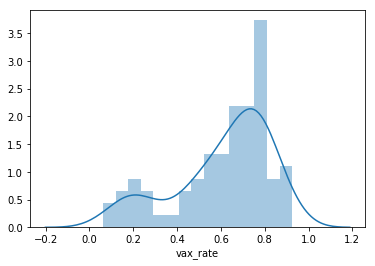

In [5]:
df['vax_rate']= df.people_fully_vaccinated/df.population
sns.distplot(df.vax_rate,bins = 15)

Histogram of people fully vaccinated against COVID.

*New variable correctly calculate (2pt)
Figure + Caption (2pts)*

>Vax rate is a strongly left-skewed distribution (1pt). It has one main peak around 80%, although it may be bimodal with a smaller peak around 0.2. (1pt)


### Question 3 (5 pts)
Let's look at how to explain the differences in the vaccination rates. 

First, let's consider the Human Development Index (HDI) that combines life expectancy, years of education, and GDP per capita. Make a scatterplot of HDI (x-axis) and Vaccination Rate (y-axis). 

Written answer: What relationship do you observe? Give at least 2 possible reasons that could explain such a relationship. 


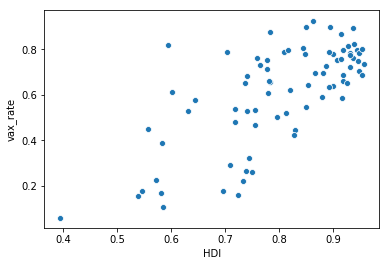

In [6]:
sns.scatterplot(df.HDI,df.vax_rate)

Scatterplot of HDI and vacc rate.

*Figure + Caption (2pts)*

>There is a positive relationship (1pt), Possible reasons: (2pts total) 
- Higher HDI may reflect higher GDP - rich countries have more resources to vaccinate
- People with more education are probably more likely to get vaccinated


### Question 4 (4 pts)
Fit a simple linear regression model, explaining vaccination rate by the human development index (HDI). 
Report the R2 value of the fit. 

Then plot the data and the prediction line. Don't forget the Figure caption. 

0.5025017754897312


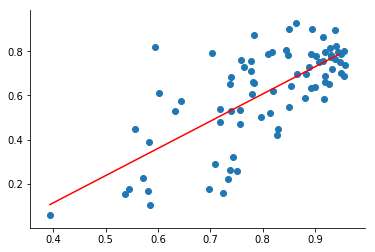

In [7]:
R2, b = multRegFit(df, df.vax_rate, ['HDI'], figure = 1)
print(R2)

Vaccination rate (y axis) as a function of human development index (x axis)

Fitting the model (1 pt), reporting the correct R2 (2 pts), figure + caption (1 pt)

### Question 5 (4 pts)
What else could explain differences in vaccination rates? We know that vaccination access varies a lot in different regions. Use boxplot to visualize vaccination rate (y axis) for different continents (x axis).

Written answer: what do you observe?

Text(0, 0.5, 'Vaccination rate')

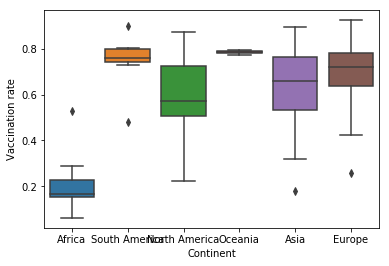

In [8]:
sns.boxplot(df.continent,df.vax_rate)
plt.xlabel('Continent')
plt.ylabel('Vaccination rate')

*Box plot (2pts)*  
>Written answer: Africa has the lowest vaccination rate. (2 pts)



### Question 6 (10 pts)
Let's investigate whether the relationship between HDI and vaccination rate still holds when we account for the geographical region. 
* First, make a dummy-coded variable that indicates whether the country is in Africa or not (using variable Continent)
* Second, restrict the data to African and European countries. *Hint: If you want a vector of True/False values that indicates whether a column in the data frame (D.col) equals A OR B, you can use  `np.logical_or(D.col==A,D.col==B)`*
* Using this restricted data, fit a regression model, using the dummy-coded variable (Africa vs Europe) and HDI as regressors. 
* Make a scatterplot of HDI against vaccination rates, with different color dots for European and African countries. In the same plot, add seperate regression lines for Africa and Europe from the model that you fit.
* Written answer: describe the resulting plot. How do the two regrssion lines differ? What does it mean?

0.8091290907968287
[-0.47863122 -0.09389747  1.30460031]
R2 is 0.81


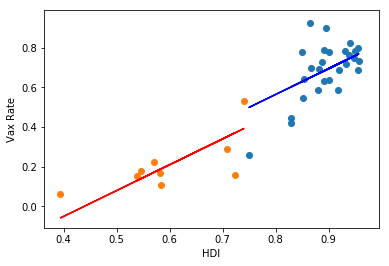

In [54]:
df['isAfrica']=np.double(df.continent=="Africa")
#R=df2[np.logical_or(df2.continent=='Europe',df2.continent=='North America')]
Rp = df.loc[(df.continent=='Europe') | (df.continent=='Africa')]
plt.scatter(Rp.HDI[Rp.isAfrica==0],Rp.vax_rate[Rp.isAfrica==0])
plt.scatter(Rp.HDI[Rp.isAfrica==1],Rp.vax_rate[Rp.isAfrica==1])
R2,b=multRegFit(Rp, Rp.vax_rate, ['isAfrica','HDI'])
print(R2)
print(b)
yp = multRegPredict(b,Rp,['isAfrica','HDI'])
plt.plot(Rp.HDI[Rp.isAfrica==0],yp[Rp.isAfrica==0],'b-')
plt.plot(Rp.HDI[Rp.isAfrica==1],yp[Rp.isAfrica==1],'r-')
plt.xlabel('HDI')
plt.ylabel('Vax Rate')
print("R2 is {0:3.2f}".format(R2))

>The regression lines have the same slope, but different intercept (it is higher for Europe). The difference in intercept means that, given equal HDI, the vaccination rate in African is lower than in Europe (different means). The same slope means that the vaccination rate increases equally with increases in HDI for both Europe and Africa.

*Dummy coding for Africa (2pts), Restriction to Africa and Europe (2pts), Fit correct regression (2pts), Plot prediction and caption (2pts), Written answer (2 pts)*

### Question 7 (8 pts)
Use Bootstrap analysis (1000 iterations) to determine whether the relationship between Human Development Index and vaccination rate is significant when we account for whether the country is European or African. Again, limit the analysis to European and African countries only. Report the confidence intervals for the influence of continent and HDI separately. 

Written answer: What do you conclude from the bootstrap in terms of the significance of a relationship between HDI and vaccination rate? What claims can you make? 

In [11]:
#Bb=bootstrapReg(df2,df2.people_fully_vaccinated_per_hundred,['isEurope + human_development_index'],multRegPredict)
params = bootstrapReg(Rp,Rp['vax_rate'],['isAfrica','HDI'],multRegFit,numIter=1000)
Int1=confidenceInt(params[:,1],95)
Int2=confidenceInt(params[:,2],95)
print("Confidence interval for influence of Continent {0:3.2f}-{1:3.2f}".format(Int1[0],Int1[1]))
print("Confidence interval for influence of HDI {0:3.3f}-{1:3.3f}".format(Int2[0],Int2[1]))

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

Confidence interval for influence of Continent 0.00-0.16
Confidence interval for influence of HDI 0.233-0.927


/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stab

The CI for Continent is 0.00 - 0.16

The CI for HDI is 0.233 - 0.927

*Bootstrap 3pts, Confidence Int 3pts*

> The CI for the influence of HDI does not contain zero. It means that even when we account for geographical region (continent) the influence of HDI on Infection rates stays significant, with higher Infection rates for higher HDI countries. (2pts)

## Task 2: Mortality rate (40 pts)
### Question 1 (3 pts) 
Define a new column in your dataframe called 'Mortality' which corresponds to the mortality rate. The mortality rate of a disease is defined as the probability that a patient will die, given that he or she contracted the disease (number of deaths divided by number of positive cases). Make a histogram of mortality, show the median as a vertical line, and don't forget axis labels. How do you describe the distribution in terms of symmetry and skew? 

In [47]:
#let's investigate mortality
mort = df.total_deaths/df.total_cases
df.insert(0, 'Mortality', mort)

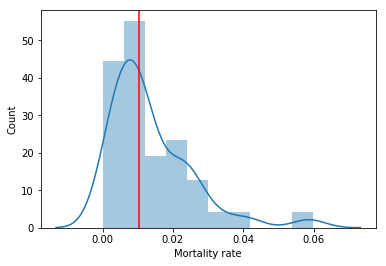

In [48]:
sns.distplot(df['Mortality'])
plt.xlabel('Mortality rate')
plt.ylabel('Count')
plt.axvline(np.median(mort), color='r')

*Calculation (1pt), Plot (1pt)*.
>The distribution of mortality rate appears to be asymmetric and right skewed (1pt), with most observations in the two lowest bins. There is a long tail on the right (higher mortality). 

### Question 2  (6 pts)
Why may TotalDeaths/TotalCases not be a good estimator for the true mortality rate? See the definition of Mortality rate in question 1. Name at least 1 factor that could make your estimate lower than the true mortality rate, and 1 factor that would make the estimate higher than the true mortality rate. For each factor you describe, explain what data a research team could realistically acquire within a month of work to make the estimate of mortality better.

Underestimate 
- Currently confirmed cases may still die: Track the currently infected patients for a month and see who will die. 
- Not all COVID19 related death maybe reported as such: Look at increases in Mortality rate overall in comparision to previous years, to figure out how many cases may be unreported. 

Overestimate: 
- There may be many more (asymptomatic or mild) infections than the confirmed ones: Randomly sample or test everybody in a given population and compare this positive rate to previously confirmed number of cases. 

*1 pt for each good reason and each correct fix*

### Question 3 (5 pts) 
Question 3-6 look at the influence of human development index (HDI) and number of hospital beds per 1000 people ('hospital_beds') on mortality rate. First, run a multiple regression analysis of mortality (response variable) as a function of HDI (with figure, don't forget to label the axes). 

Written answer: How would you describe the relationship between HDI and mortality? Write down the regression equation. Report the R2 value and the slope value for HDI. What does the R2 and the slope value mean? 

The R2 value is 0.165
The slope value is -0.038


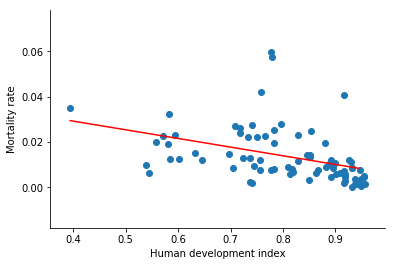

In [49]:
R2_hdi, b = multRegFit(df, df.Mortality, ['HDI'], figure = 1)
plt.xlabel('Human development index')
plt.ylabel('Mortality rate')
print(f'The R2 value is {R2_hdi:1.3f}')
print(f'The slope value is {b[1]:1.3f}')

>The regression equation is mortality = b0 + b1 \* HDI. The R2 value is 0.165, thus HDI can explain (or fit) nearly 17% of the variance. The slope value is -0.038, which means that for each point increase in HDI mortality decreased by 0.038 points. The relationship is negative.

*Regression 1pt, complete plot 1pt, equation 1pt, correct R2 and slope interpretation 2pt* 

### Question 4 (4 pts)
Run a multiple regression analysis of mortality as a function of number of hospital beds (with figure).  Again, report the R2 value and the slope for hospital beds. Based on the slope, does the number of hospital beds have an influence on mortality? 

The R2 value is 0.0602314844
The slope value is -0.0011824275


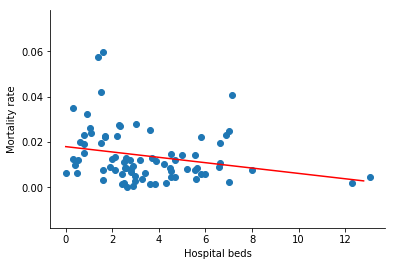

In [50]:
R2_diab, b = multRegFit(df, df.Mortality, ['hospital_beds'], figure = 1)
plt.xlabel('Hospital beds')
plt.ylabel('Mortality rate')
print(f'The R2 value is {R2_diab:1.10f}')
print(f'The slope value is {b[1]:1.10f}')

>The R2 is 0.06 (6% of the variance). The slope value is slightly negative, indicating slightly negative relationship between mortality and hospital beds.

*Regression 2pt, complete plot 1pt, description 1pt*

### Question 5  (4 pts)
Now run a multiple regression analysis of mortality with both HDI and hospital beds as predictors. How has R2 changed from the answer the obtained in Question 3? Based on the new slope, what can you conclude about the influence of HDI on mortality (after controlling for the number of hospital beds)? 

In [51]:
R2_both, b = multRegFit(df, df.Mortality, ['HDI', 'hospital_beds'])
print(f'The R2 value for both is {R2_both:1.10f}')
print(f'The R2 value for HDI alone was {R2_hdi:1.10f}')
print('The sum of both R2 values is:', R2_hdi + R2_diab)
b

The R2 value for both is 0.1667231312
The R2 value for HDI alone was 0.1649399802
The sum of both R2 values is: 0.22517146460916504


array([ 0.04331103, -0.03579085, -0.00023742])

>The combined R2 (both) is lower than the sum of the individual R2 for HDI and hospital beds, meaning that there is explaining away going on. The influence of HDI on mortality has increased slightly from -0.038 to -0.0356, meaning that the relationship became less negative after controlling for hospital beds. HDI and hospital beds explain some of the same variance, so adding the hospital beds decreases the contribution of HDI.

*Regression 2pt, written answer 2pt*

### Question 6 (6 pts)
Use Leave-one-out-crossvalidation and forward step-wise-regression to build the best predictive model of mortality using as candidates the five explanatory variables: HDI, diabetes prevalence, median age, hospital beds, and vaccination rate.

Show all steps of the step-wise regression explicitly and comment on the decisions you make in the process (and why you made them). Report the formula for the best predictive model that you found. 

In [52]:
KfoldCVmultReg(df, df.Mortality, ['HDI'])

0.13383739254503757

In [53]:
KfoldCVmultReg(df, df.Mortality, ['diabetes_prevalence'])

-0.042328367073602324

In [54]:
KfoldCVmultReg(df, df.Mortality, ['median_age'])

0.10181149253785882

In [55]:
KfoldCVmultReg(df, df.Mortality, ['vax_rate'])

0.03227256678414836

In [56]:
KfoldCVmultReg(df, df.Mortality, ['hospital_beds'])

0.02064129231603251

>The best predictor of mortality is HDI. This explanatory variable is therefore included in the best model. We now add the three remaining explanatory variables in turn. 

In [57]:
KfoldCVmultReg(df, df.Mortality, ['HDI', 'diabetes_prevalence'])

0.12967500469271864

In [58]:
KfoldCVmultReg(df, df.Mortality, ['HDI', 'median_age'])

0.10876993563380566

In [59]:
KfoldCVmultReg(df, df.Mortality, ['HDI', 'vax_rate'])

0.12108688352654629

In [60]:
KfoldCVmultReg(df, df.Mortality, ['HDI', 'hospital_beds'])

0.11590595474631149

>The addition of a second regressor is not improving prediction accuracy any further. Therefore, we stop the model selection process. The best predictive model is: mortality = b0 + b1 \* HDI 

*Step-wise CV regression 3pt, explanations 2pt, formula 1pt*

### Question 7 (2 pts)
Let's now look at mortality rate by continent. Make a boxplot of continent on the x-axis and mortality on the y-axis. Which continent has the highest overall mortality?  

Text(0, 0.5, 'Mortality rate')

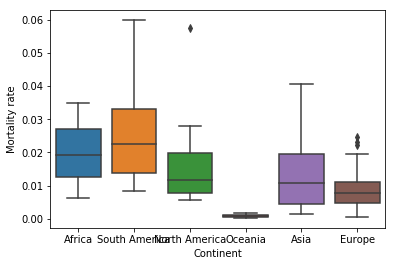

In [61]:
sns.boxplot(df.continent,df.Mortality)
plt.xlabel('Continent')
plt.ylabel('Mortality rate')

>South America has the highest median mortality rate.

*Plot 1pt, written answer 1pt*

### Question 8  (5 pts)
Create a set of 5 dummy variables that together code the continents. Set Oceania to be your comparison group. Run a multiple regression model with the 5 dummy variables as explanatory variables. Report the interecept and slope values. What do the intercept and slope values mean? 

In [62]:
df['AF'] = np.double(df.continent=='Africa')
df['SA'] = np.double(df.continent=='South America')
df['NA'] = np.double(df.continent=='North America')
df['AS'] = np.double(df.continent=='Asia')
df['EU'] = np.double(df.continent=='Europe')

In [63]:
R2, b = multRegFit(df, df.Mortality, ['AF','SA','NA','AS','EU'])
print("B:{0:3.3f}".format(b[0]))
print("B:{0:3.3f}".format(b[1]))
print("B:{0:3.3f}".format(b[2]))
print("B:{0:3.3f}".format(b[3]))
print("B:{0:3.3f}".format(b[4]))
print("B:{0:3.3f}".format(b[5]))
R2

B:0.001
B:0.018
B:0.025
B:0.016
B:0.012
B:0.008


0.21514395375703743

> The intercept is 0.001, which is the average mortality rate for Oceania<br> 
The slope for Africa is 0.018, which means that the mortality rate in AF is 18 times higher than in OC<br>
The slope for South America is 0.025, which means that the mortality rate in SA is 25 times higher than in OC<br>
The slope for North America is 0.016, which means that the mortality rate in NA is 16 times higher than in OC<br>
The slope for Asia is 0.012, which means that the mortality rate in AS is 12 times higher than in OC<br>
The slope for Europe is 0.008, which means that the mortality rate in EU is 8 times higher than in OC<br>

*Dummy variables 2 pts, multiple regression 1 pt, written answer 2pt*

### Question 9  (5 pts)
Repeat the same model but this time add human development index (HDI) as one of the regressors. Report R2. How does the R2 change? Is it meaningful?

In [64]:
R2, b = multRegFit(df, df.Mortality, ['AF','SA','NA','AS','EU', 'HDI'])
R2

0.3013698117307121

>Yes, adding HDI results in a higher R2, but we can't say whether the model is better without crossvalidation.

*Full answer 2pt, partial answer 1pt*

Now use cross-validation to compare the following two models:
1. mortality as a function of continents (previous question)
2. mortality as a function of continents and HDI

Which model is better? How do you explain changes in R2 with the addition of HDI? What do you conclude about the effect of the continent on mortality?

In [65]:
KfoldCVmultReg(df, df.Mortality, ['AF','SA','NA','AS','EU'])

0.054175264437619775

In [66]:
KfoldCVmultReg(df, df.Mortality, ['AF','SA','NA','AS','EU', 'HDI'])

0.11783004110070239

>The model improves when we add HDI to the continents (from 5 to 11% of explained variance), meaning that there is residual variability in mortality not simply explained by continent. Also, HDI alone was at 13%, meaning that it is a better predictor of mortality than continent.

*Cross-validation 2pt, written answer 1pt*

## Task 3: Logistic regression (20 pts)
### Question 1 (5 pts) 
Generate a new column in the data frame called high_gdp that assigns a value of 1 to indices with GDP larger than 15000, and 0 to the rest. Make a scatter plot (with labeled axes, and caption) that shows life expectancy on the x-axis and high_gdp on the y axis. Written answer: what do you observe?

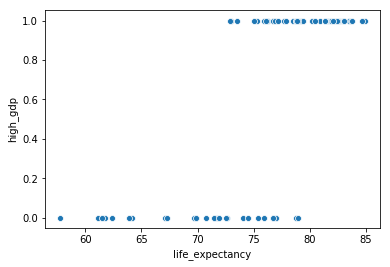

In [67]:
df['high_gdp'] = np.double(df['gdp_per_capita']>15000) 
sns.scatterplot(df.life_expectancy, df.high_gdp)

>Although there is considerable overlap, it looks like countries with higher life expectancy are also those with a higher GDP.

*New variable 2pt, full plot 2pt, written answer 1pt*

### Question 2 (5 pts) 
Fit a logistic regression model that predicts whether a country has high or low GDP based on its life expectancy. Make sure to return a figure of the results (complete with axes and caption). Print out the optimal parameters and interpret your result (negative log likelihood). Is it meaningful? 

The negative LL of the best model is 24.231
The optimal parameters are -40.965 and 0.546


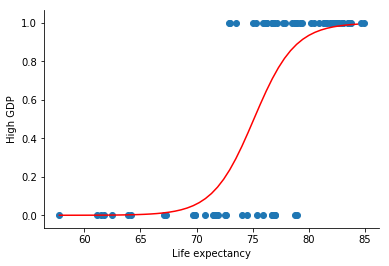

In [68]:
LL, b = logisticRegFit(df, df.high_gdp, ['life_expectancy'], figure=1) 
plt.xlabel('Life expectancy')
plt.ylabel('High GDP')
print(f'The negative LL of the best model is {-LL:1.3f}')
print(f'The optimal parameters are {b[0]:1.3f} and {b[1]:1.3f}')

>We obtained a log likelihood of -24 with parameters -40 and 0.5. However, the absolute value of the LL has no meaning by itself, we need to compare it to a different model. 

*Logistic regression 2pt, full plot 1pt, written answers 2pt*

### Question 3 (4 pts) 
Now try a different logistic regression model that uses both life expectancy and mortality to predict whether a country has high GDP or not. How does the model compare to the previous one? Explain whether we can interpret the difference between the two models and motivate why.

In [69]:
LL, b = logisticRegFit(df, df.high_gdp, ['life_expectancy','Mortality']) 
print(f'The negative LL of the best model is {-LL:1.3f}')
print(f'The optimal parameters are {b[0]:1.3f} and {b[1]:1.3f}')

The negative LL of the best model is 23.279
The optimal parameters are -38.914 and 0.527


>The new model has a slightly lower negative LL than the previous one, suggesting that it could be better. However, we need to compare crossvalidated negative LL to decide which model is better.

*Logistic regression 2pt, full written answers 2pt*

### Question 4 (6 pts)
Using leave-one-out-crossvalidation, compare first the simple intercept model (b0 only) to the model that also uses life expectancy as explanatory variable for high GDP (on top of the intercept).

Next, compare this model (intercept + life expectancy) to one that additionally includes also the human development index (HDI).

For each comparison, calculate the the difference in crossvalidated log-likelihood and answer the following questions: which one is the best model? How confident are you in your result?

In [70]:
llcv0 = KfoldCVlogisticReg(df, df.high_gdp, [ ])
llcv1 = KfoldCVlogisticReg(df, df.high_gdp, ['life_expectancy'])
llcv1-llcv0

27.42031110119276

>The winning model is the one with life expectancy. The difference in negative LL >5 indicates a very strong evidence.

*CV logistic regression 2pt, written answer 1pt*

In [71]:
llcv0 = KfoldCVlogisticReg(df, df.high_gdp, ['life_expectancy'])
llcv1 = KfoldCVlogisticReg(df, df.high_gdp, ['life_expectancy','HDI'])
llcv1-llcv0

8.328922571728

>The winning model is the one with both life expectancy and HDI. There is strong evidence in its favor (difference in negative LL > 5).

*CV logistic regression 2pt, written answer 1pt*